<a href="https://colab.research.google.com/github/hoangDEVteams/deeplearning/blob/main/animal10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import file kaglle.json để tải dữ liệu dataset từ kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoanglearning","key":"139107b7e925ade6c0a1bdd6e66865c6"}'}

đây là file cấu hình của kaggle dùng để tải dataset

In [2]:
import os

# Tạo thư mục ~/.kaggle nếu chưa có
os.makedirs("/root/.kaggle", exist_ok=True)

# Di chuyển file kaggle.json vào thư mục ~/.kaggle
!mv kaggle.json /root/.kaggle/

# Đặt quyền truy cập (bắt buộc để tránh lỗi)
!chmod 600 /root/.kaggle/kaggle.json


tải dataset từ kaggle

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 586M/586M [00:06<00:00, 140MB/s]
100% 586M/586M [00:06<00:00, 88.9MB/s]


In [4]:
import zipfile

# Giải nén file ZIP
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Giải nén thành công!")

✅ Giải nén thành công!


kiểm tra dữ liệu

In [5]:
import os
print(os.listdir("/content/data"))

['raw-img', 'translate.py']


In [6]:
import glob

image_paths = glob.glob("/content/data/**/*.jpg", recursive=True)  # Lấy tất cả file .jpg
print(f"📸 Tìm thấy {len(image_paths)} ảnh trong dataset.")
print("📜 Một số đường dẫn ảnh:")
print("\n".join(image_paths[:5]))  # In 5 ảnh đầu tiên


📸 Tìm thấy 1919 ảnh trong dataset.
📜 Một số đường dẫn ảnh:
/content/data/raw-img/ragno/eb30b5062df5063ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg
/content/data/raw-img/ragno/e034b90b20f11c22d2524518b7444f92e37fe5d404b0144390f8c47ba6ebb4_640.jpg
/content/data/raw-img/ragno/eb32b50c2df0083ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb5b1_640.jpg
/content/data/raw-img/ragno/eb30b8062df5013ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb3b9_640.jpg
/content/data/raw-img/ragno/ea35b7082bf3043ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg


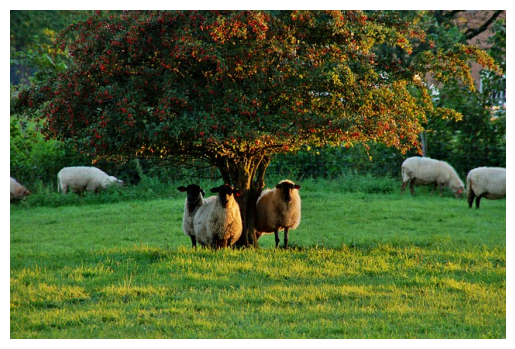

In [7]:
import cv2
import matplotlib.pyplot as plt

# Đường dẫn đến một ảnh mẫu (thay đổi đường dẫn theo thư mục dataset)
img_path = "/content/data/raw-img/pecora/ea36b10e21f5093ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg"

# Đọc ảnh bằng OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh
plt.imshow(img)
plt.axis("off")
plt.show()


Xử lý dữ liệu

In [10]:
import cv2

def preprocess_image(img_path):
    img_size = 90
    img = cv2.imread(img_path)  # Đọc ảnh (mặc định là BGR)
    img = cv2.resize(img, (img_size, img_size))  # Resize về kích thước cố định
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB
    return img

img_array = preprocess_image("/content/data/raw-img/pecora/ea37b60d2ef1043ed1584d05fb1d4e9fe777ead218ac104497f5c978a6e8b0b1_640.jpg")
print(img_array.shape)  # Kết quả mong đợi: (90, 90,


(90, 90, 3)


Bạn cần chia dataset thành 3 phần để huấn luyện và đánh giá mô hình:

Train set (~70-80%): Dùng để huấn luyện.

Validation set (~10-15%): Dùng để tối ưu mô hình, tránh overfitting.


Test set (~10-15%): Đánh giá mô hình sau khi train.

In [8]:
from sklearn.model_selection import train_test_split
image_paths = glob.glob("/content/data/**/*.jpg", recursive=True)
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
train_paths, val_paths = train_test_split(train_paths, test_size=0.1, random_state=42)

print(f"📂 Train: {len(train_paths)} ảnh")
print(f"📂 Validation: {len(val_paths)} ảnh")
print(f"📂 Test: {len(test_paths)} ảnh")

📂 Train: 1381 ảnh
📂 Validation: 154 ảnh
📂 Test: 384 ảnh


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = 90
datagen = ImageDataGenerator(rescale=1./90, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/content/data/raw-img/",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    "/content/data/raw-img/",
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


xây dưng mô hình CNN

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [12]:
img_size = 90
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 lớp output vì có 10 loại động vật
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Hiển thị kiến trúc model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 88, 88, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,407,306 (20.63 MB)

 Trainable params: 5,407,306 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

epochs trong huấn luyện mô hình deep learning là số lần toàn bộ dataset được đưa qua mô hình trong quá trình huấn luyện.

📌 Giải thích chi tiết:
Khi bạn huấn luyện mô hình, dữ liệu được chia thành nhiều batch (tập nhỏ).

Một epoch là khi mô hình được huấn luyện trên toàn bộ dữ liệu huấn luyện một lần.

Nếu bạn đặt epochs = 20, nghĩa là mô hình sẽ lặp qua toàn bộ dữ liệu 20 lần.

Giả sử bạn có 1.000 ảnh trong dataset và batch_size=32, thì:

Mỗi batch có 32 ảnh.
Số batch mỗi epoch = 1000 / 32 ≈ 31 batch.
Nếu epochs = 20, mô hình sẽ chạy 31 × 20 = 620 batch.

In [13]:
epochs = 20  # Tăng số epochs nếu cần
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


655/655 ━━━━━━━━━━━━━━━━━━━━ 373s 565ms/step - accuracy: 0.3145 - loss: 1.9559 - val_accuracy: 0.5365 - val_loss: 1.3339
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 372s 567ms/step - accuracy: 0.5498 - loss: 1.3288 - val_accuracy: 0.6149 - val_loss: 1.1192
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 385s 587ms/step - accuracy: 0.6320 - loss: 1.0741 - val_accuracy: 0.6359 - val_loss: 1.0720
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 424s 560ms/step - accuracy: 0.7035 - loss: 0.8792 - val_accuracy: 0.6860 - val_loss: 0.9728
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 369s 563ms/step - accuracy: 0.7690 - loss: 0.6931 - val_accuracy: 0.6917 - val_loss: 0.9568
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 356s 544ms/step - accuracy: 0.8197 - loss: 0.5343 - val_accuracy: 0.6913 - val_loss: 1.0337
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 358s 546ms/step - accuracy: 0.8712 - loss: 0.3894 - val_accuracy: 0.6974 - val_loss: 1.0830
Epoch 8/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 357s 545ms/step - accuracy: 0.8974 - loss: 0.30

In [14]:
model.save("model_animals.h5")  # Lưu mô hình sau khi train xong

In [15]:
from tensorflow.keras.models import load_model

model = load_model("model_animals.h5")  # Load mô hình đã lưu


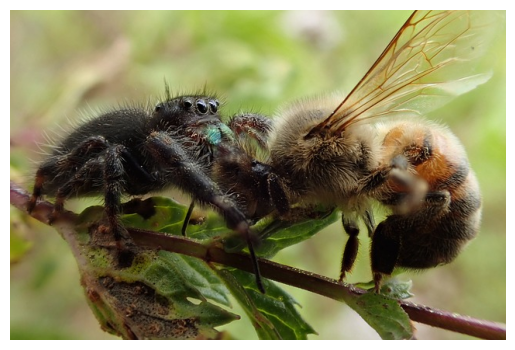

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    img_size = 90  # Cùng kích thước với dữ liệu huấn luyện
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
    img = img / 255.0  # Chuẩn hóa về khoảng [0, 1]
    return np.expand_dims(img, axis=0)  # Thêm batch dimension (1, 90, 90, 3)

# Chọn ảnh để test
img_path = "/content/data/raw-img/ragno/eb32b50c2df0083ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb5b1_640.jpg"
img_test = preprocess_image(img_path)

# Đọc ảnh
img_path = "/content/data/raw-img/ragno/eb32b50c2df0083ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb5b1_640.jpg"
img = cv2.imread(img_path)

# Kiểm tra nếu ảnh bị lỗi
if img is None:
    print("❌ Không thể đọc ảnh! Kiểm tra lại đường dẫn.")
else:
    # Chuyển ảnh từ BGR (OpenCV) sang RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh
    plt.imshow(img_rgb)
    plt.axis("off")  # Ẩn trục
    plt.show()


In [19]:
predictions = model.predict(img_test)  # Dự đoán
predicted_class = np.argmax(predictions)  # Lấy class có xác suất cao nhất
print("Dự đoán của mô hình:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Dự đoán của mô hình: 8


In [20]:
class_labels = ["butterfly", "cat", "cow", "dog", "elephant", "hen", "horse", "sheep", "spider", "squirrel"]
print("Tên loài vật dự đoán:", class_labels[predicted_class])


Tên loài vật dự đoán: spider
